In [2]:
# Set up feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.ethics.ex4 import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data, separate features from target
data = pd.read_csv("../input/synthetic-credit-card-approval/synthetic_credit_card_approval.csv")
data.head()

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1


In [25]:
data['Group'].value_counts()

1    250325
0    249675
Name: Group, dtype: int64

In [3]:
!pip install fairlearn --quiet
import fairlearn

In [11]:
# Get features into X and target into Y as label
X = data.drop(["Target"], axis=1)
y = data["Target"]

# Break into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [12]:
from fairlearn.preprocessing import CorrelationRemover

# Apply Correlation Remover on sensitive feature 'Group' for X_train
cr = CorrelationRemover(sensitive_feature_ids=['Group'])
dcr = cr.fit_transform(X_train)
dcr = pd.DataFrame(dcr, columns = ['Num_Children', 'Income', 'Own_Car', 'Own_Housing'])

In [13]:
# Add Group back into the features since CorrelationRemover drops the sensitive group
grp = X_train["Group"]
grp = grp.reset_index(drop = True)
dcr["Group"] = grp

In [14]:
np.isnan(dcr).value_counts()

Num_Children  Income  Own_Car  Own_Housing  Group
False         False   False    False        False    400000
dtype: int64

In [15]:
# Reorder columns
dcr = dcr[['Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing']]

In [21]:
round(X_train.corr(), 5)

,Num_Children,Group,Income,Own_Car,Own_Housing
Num_Children,1.00000,-0.00020,-0.00192,0.00146,0.00056
Group,-0.00020,1.00000,0.32625,0.21804,0.20230
Income,-0.00192,0.32625,1.00000,0.06913,0.06348
Own_Car,0.00146,0.21804,0.06913,1.00000,0.04381
Own_Housing,0.00056,0.20230,0.06348,0.04381,1.00000


In [22]:
round(dcr.corr(), 5)

,Num_Children,Group,Income,Own_Car,Own_Housing
Num_Children,1.00000,-0.0,-0.00196,0.00154,0.00061
Group,-0.00000,1.0,-0.00000,-0.00000,0.00000
Income,-0.00196,-0.0,1.00000,-0.00217,-0.00272
Own_Car,0.00154,-0.0,-0.00217,1.00000,-0.00031
Own_Housing,0.00061,0.0,-0.00272,-0.00031,1.00000


In [26]:
# Check group balance
dcr["Group"].value_counts()

1    200295
0    199705
Name: Group, dtype: int64

In [39]:
# Repeat CorrelationRemover to X_test
dcr_test = cr.fit_transform(X_test)
dcr_test = pd.DataFrame(dcr_test, columns = ['Num_Children', 'Income', 'Own_Car', 'Own_Housing'])

tgrp = X_test["Group"]
tgrp = tgrp.reset_index(drop = True)
dcr_test["Group"] = tgrp

dcr_test = dcr_test[['Num_Children', 'Group', 'Income', 'Own_Car', 'Own_Housing']]

In [96]:
from sklearn import tree # decision tree  tree.DecisionTreeClassifier
from sklearn import linear_model # logistic  linear_model.LogisticRegression
from sklearn import ensemble #boosted decision tree  ensemble.GradientBoostingClassifier, ensemble.RandomForestClassifier,  ensemble.AdaBoostClassifier
# from sklearn import svm # svm svm.SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Train a model and make predictions
model_baseline = ensemble.GradientBoostingClassifier(random_state=0)
model_baseline.fit(dcr, y_train)
preds_baseline = model_baseline.predict(dcr_test)

# Function to plot confusion matrix
def plot_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                          include_values=True, xticks_rotation='horizontal', values_format='',
                          normalize=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    return cm, disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation,
                     values_format=values_format)

Total approvals: 38677
Group A: 9964 (25.76% of approvals)
Group B: 28713 (74.24% of approvals)

Overall accuracy: 97.25%
Group A: 97.08%
Group B: 97.43%

Sensitivity / True positive rate:
Group A: 93.62%
Group B: 97.51%


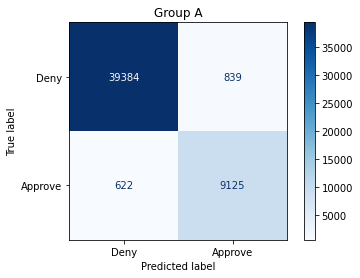

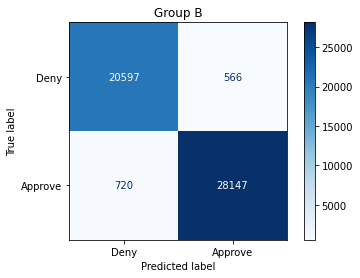

In [97]:
# Function to evaluate the fairness of the model
# Reset index to prevent error
def get_stats(X, y, model, group_one, preds):
    y = y.reset_index(drop = True)
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    print("Total approvals:", preds.sum())
    print("Group A:", preds_zero.sum(), "({}% of approvals)".format(round(preds_zero.sum()/sum(preds)*100, 2)))
    print("Group B:", preds_one.sum(), "({}% of approvals)".format(round(preds_one.sum()/sum(preds)*100, 2)))
    
    print("\nOverall accuracy: {}%".format(round((preds==y).sum()/len(y)*100, 2)))
    print("Group A: {}%".format(round((preds_zero==y_zero).sum()/len(y_zero)*100, 2)))
    print("Group B: {}%".format(round((preds_one==y_one).sum()/len(y_one)*100, 2)))
    
    cm_zero, disp_zero = plot_confusion_matrix(model, X_zero, y_zero, preds_zero)
    disp_zero.ax_.set_title("Group A")
    cm_one, disp_one = plot_confusion_matrix(model, X_one, y_one, preds_one)
    disp_one.ax_.set_title("Group B")
    
    print("\nSensitivity / True positive rate:")
    print("Group A: {}%".format(round(cm_zero[1,1] / cm_zero[1].sum()*100, 2)))
    print("Group B: {}%".format(round(cm_one[1,1] / cm_one[1].sum()*100, 2)))
    
# Evaluate the model    
get_stats(dcr_test, y_test, model_baseline, dcr_test["Group"]==1, preds_baseline)

In [111]:
sensitive_features = dcr["Group"]

from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
                    estimator=model_baseline,
                    constraints='demographic_parity',
                    objective='balanced_accuracy_score',
                    prefit=True,
                    predict_method = 'auto')
topt_model = postprocess_est.fit(dcr, y_train, sensitive_features=sensitive_features)
preds_topt = topt_model.predict(dcr_test, sensitive_features=dcr_test["Group"])

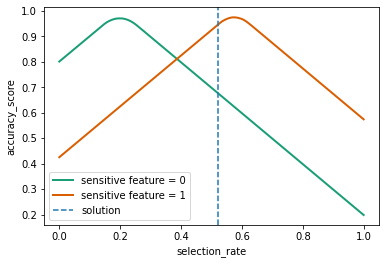

In [99]:
from fairlearn.postprocessing import plot_threshold_optimizer
plot_threshold_optimizer(postprocess_est)

Total approvals: 51918
Group A: 25852 (49.79% of approvals)
Group B: 26066 (50.21% of approvals)

Overall accuracy: 81.09%
Group A: 67.76%
Group B: 94.4%

Sensitivity / True positive rate:
Group A: 99.98%
Group B: 90.3%


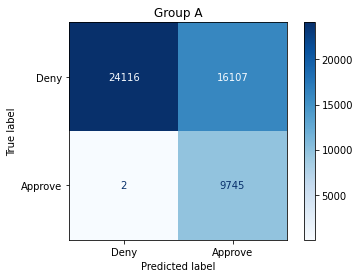

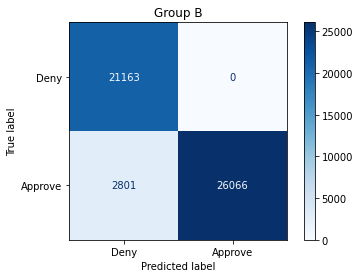

In [100]:
# accuracy score
get_stats(dcr_test, y_test, topt_model, dcr_test["Group"]==1, preds_topt)

Total approvals: 53595
Group A: 26749 (49.91% of approvals)
Group B: 26846 (50.09% of approvals)

Overall accuracy: 80.92%
Group A: 65.98%
Group B: 95.84%

Sensitivity / True positive rate:
Group A: 100.0%
Group B: 92.89%


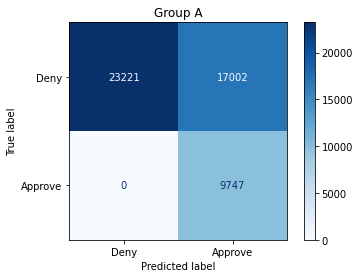

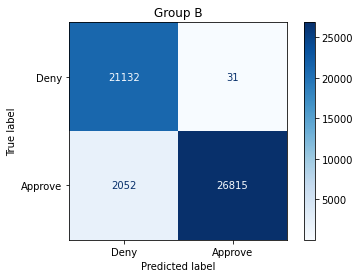

In [107]:
# balanced accuracy score
get_stats(dcr_test, y_test, topt_model, dcr_test["Group"]==1, preds_topt)

In [32]:
# def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False):
#     plot_list = tree.plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
#     [process_plot_item(item) for item in plot_list]

# def process_plot_item(item):
#     split_string = item.get_text().split("\n")
#     if split_string[0].startswith("samples"):
#         item.set_text(split_string[-1])
#     else:
#         item.set_text(split_string[0])

# plt.figure(figsize=(20, 6))
# plot_list = visualize_model(model_baseline, feature_names=dcr.columns)

Total approvals: 38704
Group A: 9913 (25.61% of approvals)
Group B: 28791 (74.39% of approvals)

Overall accuracy: 97.26%
Group A: 97.08%
Group B: 97.44%

Sensitivity / True positive rate:
Group A: 93.37%
Group B: 97.65%


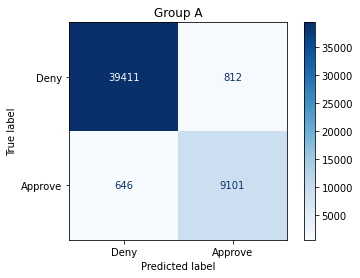

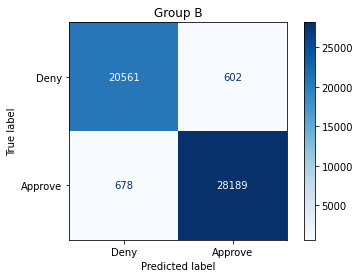

In [101]:
### Group Unaware, lets see how removing sensitive group completely performs
dcr_train_unaware = dcr.drop(["Group"],axis=1)
dcr_test_unaware = dcr_test.drop(["Group"],axis=1)

# Train new model on new dataset
model_unaware = ensemble.GradientBoostingClassifier(random_state=0)
model_unaware.fit(dcr_train_unaware, y_train)

# Evaluate the model
preds_unaware = model_unaware.predict(dcr_test_unaware)
get_stats(dcr_test_unaware, y_test, model_unaware, dcr_test["Group"]==1, preds_unaware)

In [108]:
sensitive_features = dcr["Group"]

postprocess_est = ThresholdOptimizer(
                    estimator=model_unaware,
                    constraints='demographic_parity',
                    objective='accuracy_score',
                    prefit=True,
                    predict_method = 'auto')
topt_model = postprocess_est.fit(dcr_train_unaware, y_train, sensitive_features=sensitive_features)
preds_topt = topt_model.predict(dcr_test_unaware, sensitive_features=dcr_test["Group"])

Total approvals: 52038
Group A: 25967 (49.9% of approvals)
Group B: 26071 (50.1% of approvals)

Overall accuracy: 80.98%
Group A: 67.54%
Group B: 94.41%

Sensitivity / True positive rate:
Group A: 100.0%
Group B: 90.31%


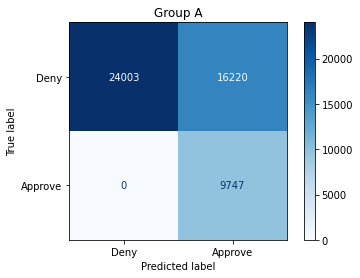

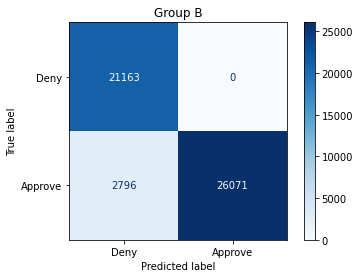

In [103]:
get_stats(dcr_test_unaware, y_test, topt_model, dcr_test["Group"]==1, preds_topt)

establish a disparity between groups, then focus on accuracy
concurrent accuracy/fairness evaluation
stick to one evaluation method
include evaluation step into report, how are we evaluating accuracy vs fairness